In [1]:
import matplotlib.pyplot as plt
import mlflow
import torch
from torchvision.transforms import Compose

from synthetic_data.api.model_registry import ModelRegistry
from synthetic_data.common.config import LocalConfig
from synthetic_data.mlops.datasets.multiharmonic import MultiHarmonicDataset
from synthetic_data.mlops.models.cgan import Generator
from synthetic_data.mlops.tools import analysis
from synthetic_data.mlops.tools.analysis import visualization
from synthetic_data.mlops.transforms.transform import RandomRoll

In [2]:
cfg = LocalConfig()
mlflow.set_tracking_uri(cfg.URI_MODELREG_REMOTE)
mlflow.set_registry_uri(cfg.URI_MODELREG_REMOTE)

model_registry = ModelRegistry()

In [3]:
dataset_names = [
    "Harmon 1",
    "Harmon 2",
    "Harmon 3",
    "Harmon 4",
    "Harmon 5",
    "Harmon 6",
    "Harmon 7",
    "Harmon 8",
    "Harmon 9",
    "Harmon 10",
]

dataset_labels = {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4,
    "6": 5,
    "7": 6,
    "8": 7,
    "9": 8,
    "10": 9,
}

transforms = Compose([RandomRoll(p=-1.0)])

dataset = MultiHarmonicDataset(
    names=dataset_names,
    label_map=dataset_labels,
    transforms=transforms,
    save=True,
    local_dir="tmp"
)

seq_length = dataset.get_sequence_length()
n_samples = len(dataset)
# NOTE: we assume equally sized datasets
n_samples_per_dataset = int(n_samples / len(dataset_names))

params = dict(
    z_dim=100,
    n_classes=10,
    z_type="normal",
    seq_length=seq_length,
    n_samples=n_samples,
    n_samples_per_dataset=n_samples_per_dataset,
)

Loaded data locally from tmp/MultiHarmonicDataset


In [4]:
wgan = model_registry.load_model("WGAN-GP", 4)
cgan = model_registry.load_model("C-GAN", 7)

2022/08/19 11:06:02 WARNING mlflow.pytorch: Stored model version '1.12.0+cu113' does not match installed PyTorch version '1.10.2+cu102'
2022/08/19 11:06:02 WARNING mlflow.pytorch: Stored model version '1.12.0+cu113' does not match installed PyTorch version '1.10.2+cu102'


## WGAN-GP: Original vs. Synthetic Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

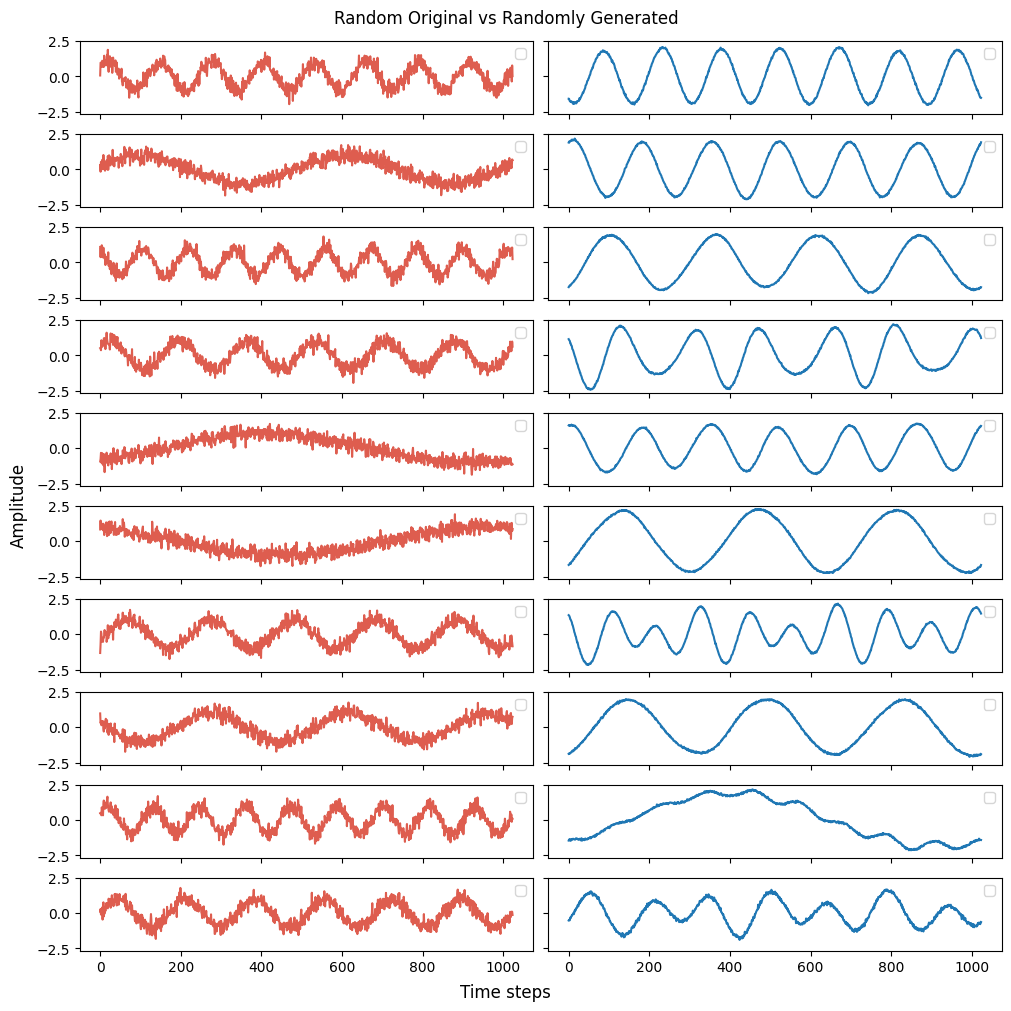

In [5]:
# WGAN
noise_shape = (params["n_classes"], params["z_dim"])
noise = torch.randn(noise_shape)
sequences = wgan(noise)

fig, axis = plt.subplots(
    nrows=len(sequences),
    ncols=2,
    figsize=(10, params["n_classes"]),
    sharex=True,
    sharey=True,
    constrained_layout=True,
    dpi=100,
)
for i in range(len(sequences)):
    random_index = torch.randint(0, params["n_samples"], (1,))[0]
    original_seq, _ = dataset[random_index]
    axis[i, 0].plot(original_seq.detach().numpy(), color="#DE5D4F")
    axis[i, 0].legend(loc="upper right")
    axis[i, 1].plot(sequences[i].detach().numpy())
    axis[i, 1].legend(loc="upper right")
fig.suptitle("Random Original vs Randomly Generated")
fig.supxlabel("Time steps")
fig.supylabel("Amplitude")
plt.show()

## C-GAN: Original vs. Synthetic Data

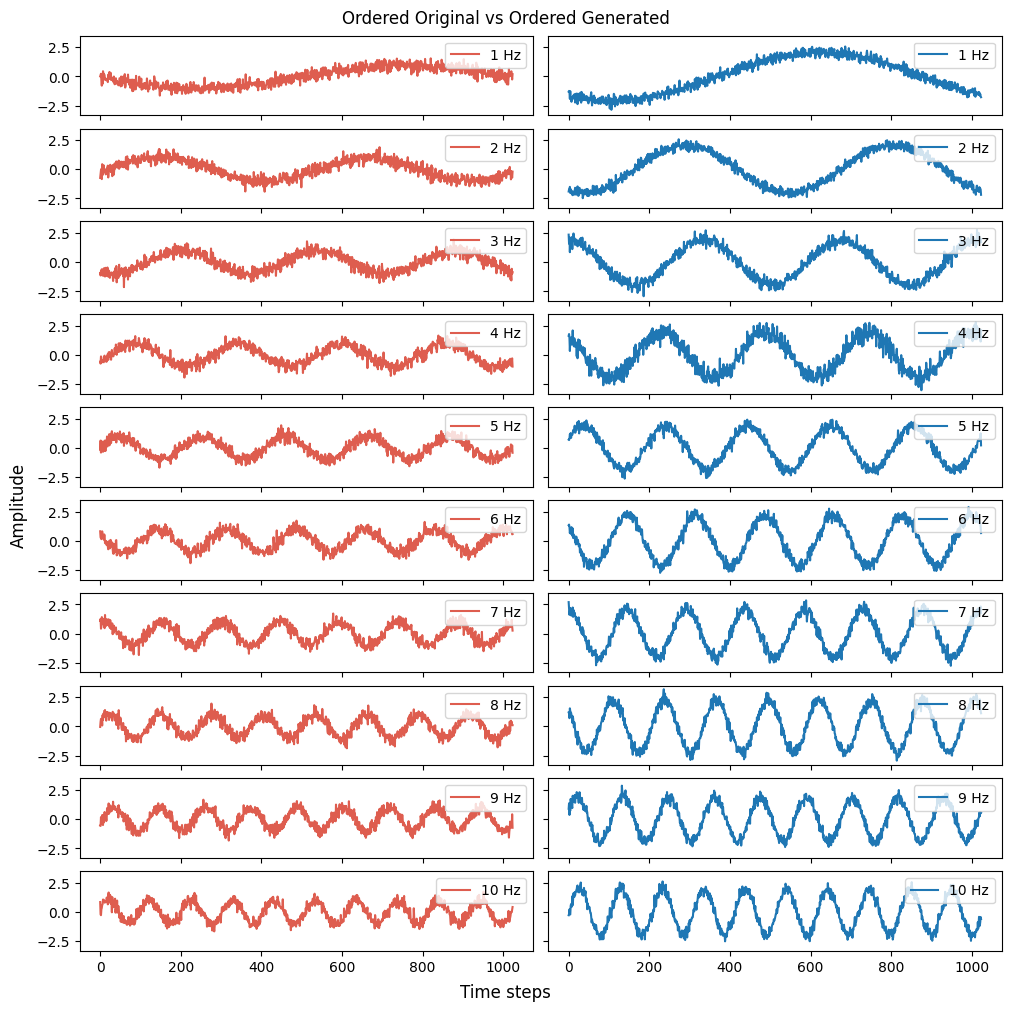

In [6]:
# CGAN
labels = torch.arange(params["n_classes"])
noise = torch.randn((labels.shape[0], params["z_dim"]))
sequences = cgan(noise, labels)

fig, axis = plt.subplots(
    nrows=len(sequences),
    ncols=2,
    figsize=(10, params["n_classes"]),
    sharex=True,
    sharey=True,
    constrained_layout=True,
    dpi=100,
)
for i in range(len(sequences)):
    original_seq, _ = dataset[i*1000+500]
    axis[i, 0].plot(original_seq.detach().numpy(), label=f"{i+1} Hz", color="#DE5D4F")
    axis[i, 0].legend(loc="upper right")
    axis[i, 1].plot(sequences[i].detach().numpy(), label=f"{i+1} Hz")
    axis[i, 1].legend(loc="upper right")
fig.suptitle("Ordered Original vs Ordered Generated")
fig.supxlabel("Time steps")
fig.supylabel("Amplitude")
plt.show()

## Generate data, extract featuers and view Average cosine similarity

In [7]:
ordered_labels = analysis.generate_labels(n_samples=params["n_samples"], n_samples_per_dataset=params["n_samples_per_dataset"], n_classes=params["n_classes"])

# NOTE: We extract the dataset orderly from 1-10 Hz when using Conditional GAN
# if not using any condition, we can't use the average cosine similarity per class, just one for all
extracted_data = analysis.extract_sequences(dataset)
generated_data = analysis.genererate_sequences(cgan, ordered_labels)

feature_extracted_data = analysis.sequences_to_features(extracted_data)
feature_generated_data = analysis.sequences_to_features(generated_data)

for i in range(params["n_classes"]):
    feat_1_A, feat_1_B = analysis.sample_datasets(index=i, data1=feature_extracted_data, data2=feature_generated_data)
    avg_cossim = analysis.avg_cos_sim(feat_1_A, feat_1_B)
    print(f"Average cosine similarity for class {i+1} Hz = {avg_cossim:.4f}")

Average cosine similarity for class 1 Hz = 0.9796
Average cosine similarity for class 2 Hz = 0.9839
Average cosine similarity for class 3 Hz = 0.9805
Average cosine similarity for class 4 Hz = 0.9902
Average cosine similarity for class 5 Hz = 0.9776
Average cosine similarity for class 6 Hz = 0.9809
Average cosine similarity for class 7 Hz = 0.9811
Average cosine similarity for class 8 Hz = 0.9804
Average cosine similarity for class 9 Hz = 0.9799
Average cosine similarity for class 10 Hz = 0.9805


### Viewing t-SNE and PCA distribution given condtions
Select one class and plot the cosine similarity between the extracted and generated data

/home/andy/dev/synthetic-data/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/andy/dev/synthetic-data/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.189s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.008589
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.866211
[t-SNE] KL divergence after 300 iterations: 1.766265


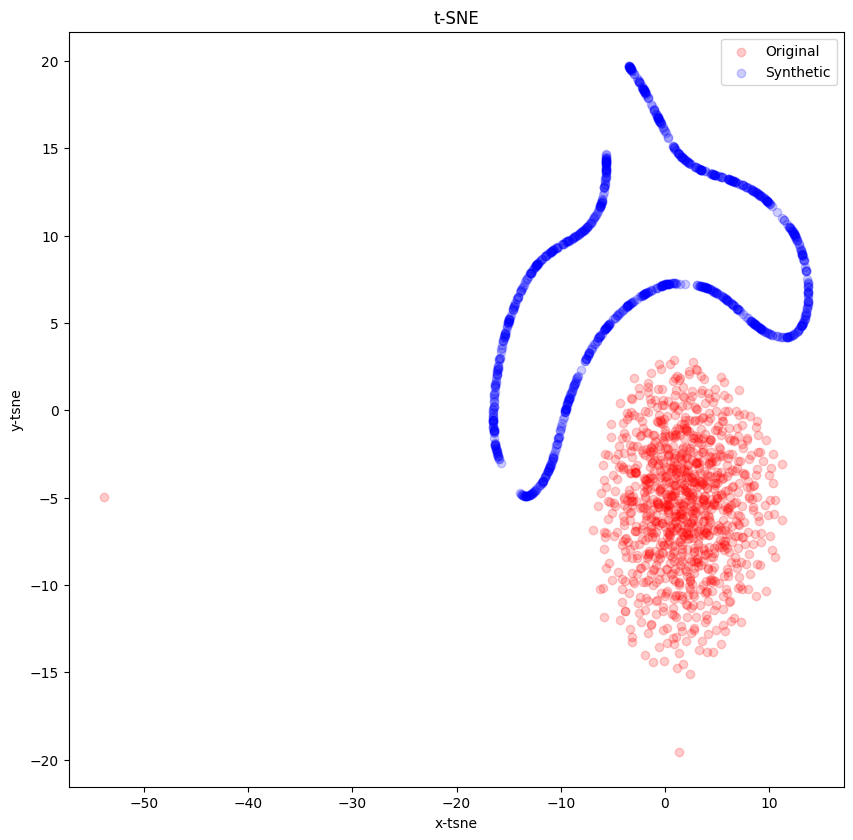

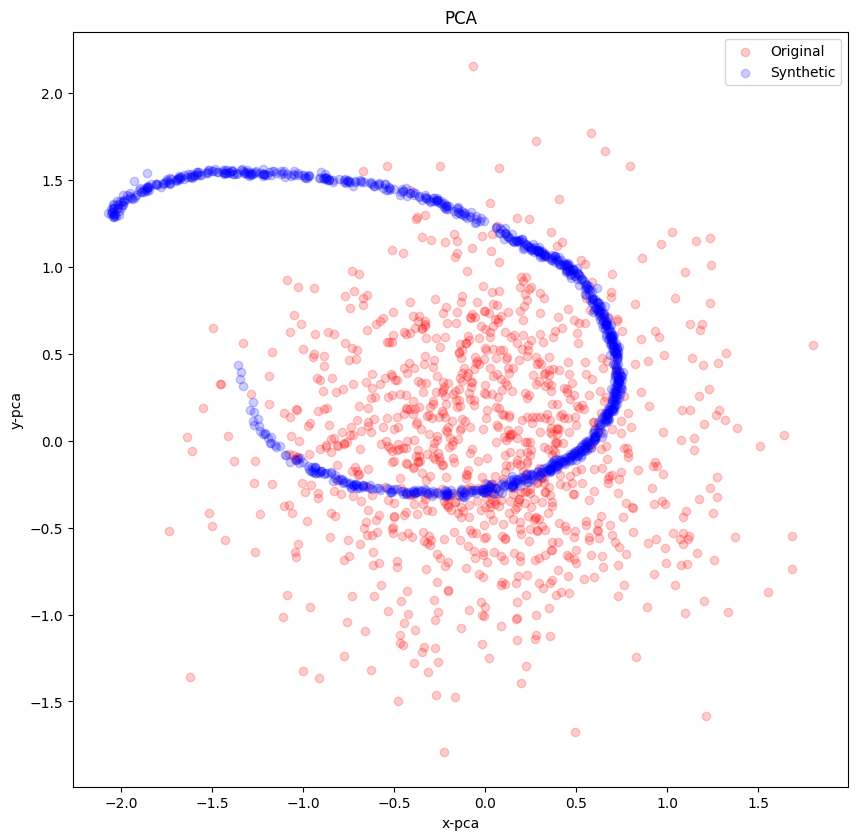

In [11]:
CLASS = 9 # 10 Hz

ds1, ds2 = analysis.sample_datasets(index=CLASS, data1=extracted_data, data2=generated_data)

shuffle = False
if shuffle:
    indices = torch.randperm(ds1.shape[0])
    ds1 = ds1[indices]
    ds2 = ds2[indices]

ds1 = ds1.unsqueeze(2).detach()
ds2 = ds2.unsqueeze(2).detach()

SAMPLE_SIZE = 1 # in decimal percent
visualization(ds1, ds2, "tsne", percent=SAMPLE_SIZE)
visualization(ds1, ds2, "pca", percent=SAMPLE_SIZE)

### Viewing t-SNE and PCA distribution of randomized data


/home/andy/dev/synthetic-data/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/andy/dev/synthetic-data/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 6.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.268726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.667629
[t-SNE] KL divergence after 300 iterations: 2.177488


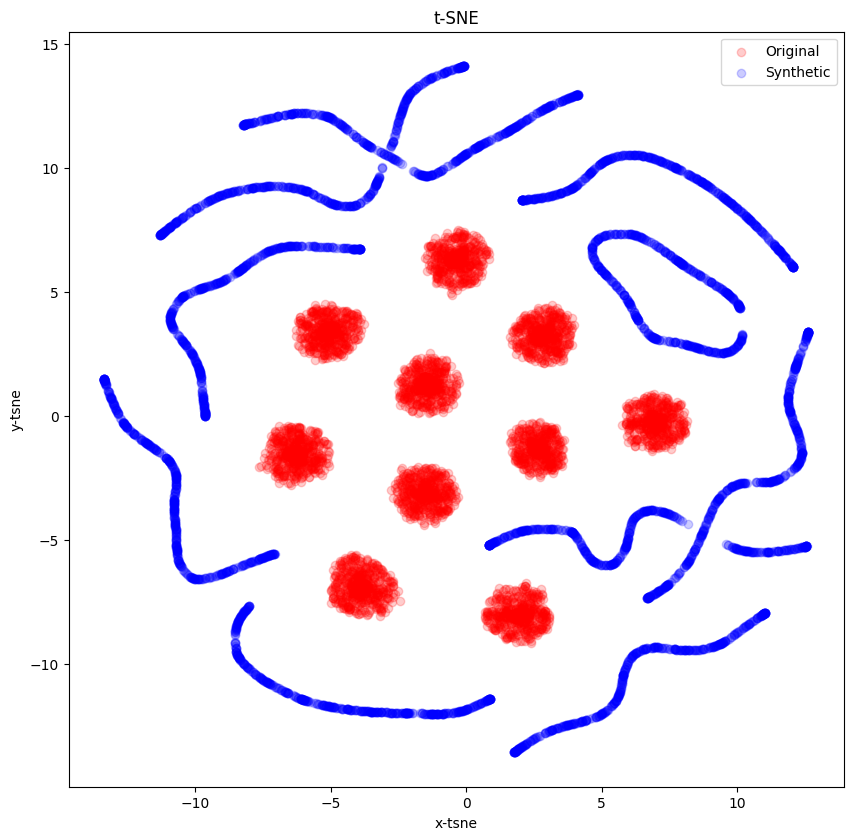

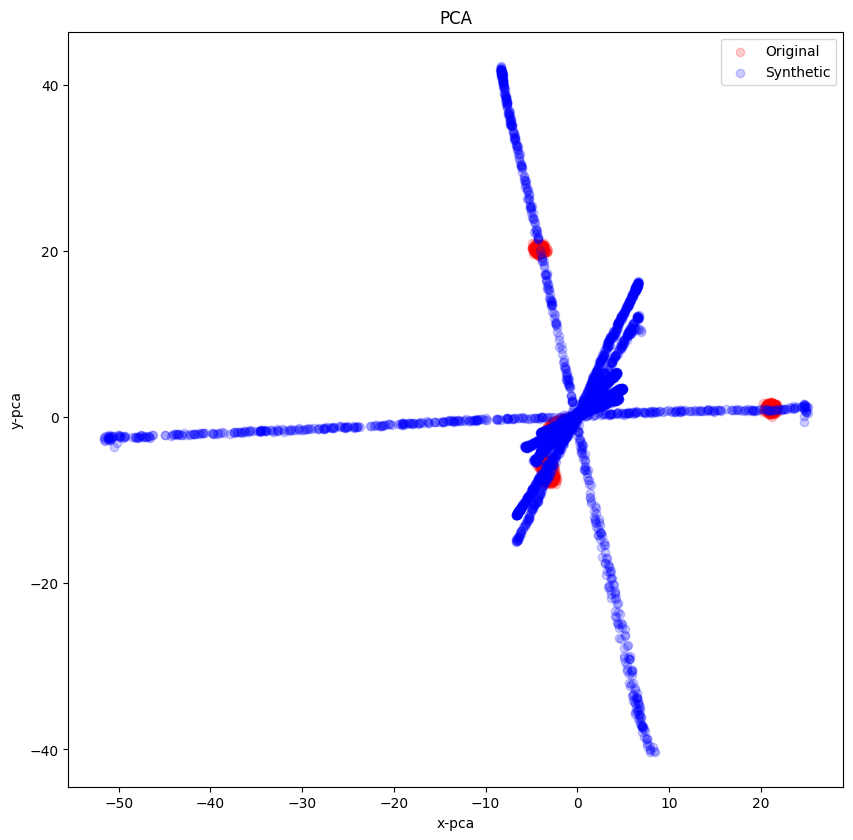

In [10]:
# indices = torch.randperm(extracted_data.shape[0])

s1 = extracted_data #[indices]
s2 = generated_data #[indices]

s1 = s1.unsqueeze(2).detach()
s2 = s2.unsqueeze(2).detach()

SAMPLE_SIZE = 0.5 # in decimal percent
visualization(s1, s2, "tsne", percent=SAMPLE_SIZE)
visualization(s1, s2, "pca", percent=SAMPLE_SIZE)